In [106]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import copy

In [107]:
def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)



# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

600

In [108]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


discriminator = DiscriminatorNet()

In [109]:
class D_unrollNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(D_unrollNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

D_unroll = D_unrollNet()

In [110]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [111]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [112]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [113]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
D_unroll = D_unrollNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [114]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
u_optimizer = optim.Adam(D_unroll.parameters(), lr=0.0002)
loss = nn.BCELoss()
#loss=nn.MSELoss()

In [115]:
def train_discriminator(optimizer, real_data, fake_data):
    
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    #torch.save(self.model.manhattan_lstm.state_dict(), 'model.pth')
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [116]:
# train D_unroll
def train_D_unroll(optimizer, real_data, fake_data):
    
    k=5
    #D_unroll=copy.deepcopy(discriminator)   
    D_unroll.load_state_dict(discriminator.state_dict())
    
    N = real_data.size(0)
    for i in range(k):
        # Reset gradients
        optimizer.zero_grad()

        # 1.1 Train on Real Data
        prediction_real = D_unroll(real_data)
        error_real = loss(prediction_real, ones_target(N) )
        error_real.backward()

        # 1.2 Train on Fake Data
        prediction_fake = D_unroll(fake_data)
        error_fake = loss(prediction_fake, zeros_target(N))
        error_fake.backward()

        # 1.3 Update weights with gradients
        optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [117]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = D_unroll(fake_data)
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [118]:
num_test_samples = 8
test_noise = noise(num_test_samples)

logger = Logger(model_name='VGAN', data_name='MNIST')

D_loss=[]
G_loss=[]
N=600
num_epochs=50
for epoch in range(num_epochs):
    LossD=0
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        LossD+=d_error.item()

        
        # 2. Train D_unroll
        real_data = Variable(images_to_vectors(real_batch))
        fake_data = generator(noise(real_data.size(0))).detach()
        u_error, u_pred_real, u_pred_fake = train_D_unroll(u_optimizer,
                                                                real_data, fake_data)
        
        # 3. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)       
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        LossG+=g_error.item()
                

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('D:',LossD/N,'G:',LossG/N)
print(D_loss,G_loss)  

Text(0, 0.5, 'Training Loss')

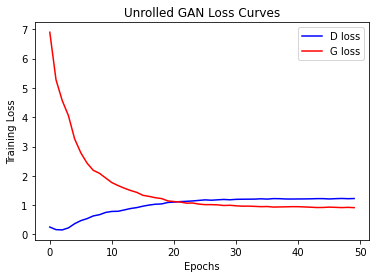

In [120]:
## plot 
plt.title('Unrolled GAN Loss Curves')
plt.plot(D_loss,'b')
plt.plot(G_loss,'r')
#plt.ylim((0.348, 0.356))
plt.legend(['D loss','G loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')


In [121]:
PATH="/Users/dl/gen_unroll"
torch.save(generator.state_dict(),PATH)
print("Succ")

Succ
